In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.38:8787/status,
Dashboard: http://10.148.1.38:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.38:37455,Workers: 0
Dashboard: http://10.148.1.38:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset

In [10]:
DS={}
_aviso_var = ['aviso_alti_matchup_g_grad_x', 'aviso_alti_matchup_g_grad_y',
              'aviso_drifter_matchup_g_grad_x','aviso_drifter_matchup_g_grad_y']
_wind_var = ['es_drifter_matchup_tauu','es_drifter_matchup_tauv',
            'es_alti_matchup_tauu','es_alti_matchup_tauv']

list_wd_srce_suffix = ['es']
list_func = [stw.cst_rio_z15, stw.cst_rio_z0]
list_func_suffix = ['cstrio_z15', 'cstrio_z0']

for l in labels[:5]: 
    #IMPORT DATA
    ds_wind = xr.open_zarr(zarr_dir+'/erastar_'+l+'.zarr')
    ds_wind = ds_wind.rename({v: 'es_'+v.replace("_es", "") for v in ds_wind if '_es'in v})
    ds_wind = ds_wind.rename({v: 'e5_'+v.replace("_e5", "") for v in ds_wind if '_e5'in v})
    ds_aviso = xr.open_zarr(zarr_dir+'/aviso_'+l+'.zarr')
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    
    ds_data = ds_data.rename({'g_grad_sla': 'g_grad_sla'.replace("sla", "x"), 'g_grad_sla_denoised': 'denoised_'+'g_grad_sla_denoised'.replace("sla_denoised", "x")})

    #DATASET FOR PDF
    ds = xr.merge(diag.datasets_for_pdfs(ds_data, ds_aviso, ds_wind, total_ds=True, except_ds=True,
                                _aviso_var = _aviso_var, _wind_var = _wind_var, 
                                list_wd_srce_suffix = list_wd_srce_suffix, list_func = list_func, list_func_suffix = list_func_suffix
                               ))
     # add momentum conservation equation term
    dt=3600
    ds['acc_e'] = ds_data.drifter_ve.differentiate("site_obs")/dt
    ds['acc_n'] = ds_data.drifter_vn.differentiate("site_obs")/dt
    ds['coriolis_e'] = -ds_data["drifter_ve"]*ds_data.f
    ds['coriolis_n'] = ds_data["drifter_vn"]*ds_data.f
    
    DS[l]=ds.persist()
    print(l)

gps_SASSA_SARAL_2018
gps_SASSA_Sentinel_2018
argos_SASSA_SARAL_2018
argos_SASSA_Sentinel_2018
argos_SASSA_Sentinel_2016


In [58]:
ds_wind

<xarray.Dataset>
Dimensions:                  (obs: 4054, box_y: 40, box_x: 80, es_time: 25,
                              site_obs: 1489)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(2027, 13), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(4054,), meta=np.ndarray>
Dimensions without coordinates: obs, es_time, site_obs
Data variables: (12/19)
    e5_alti_matchup_tauu     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    e5_alti_matchup_tauv     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    es_alti_matchup_tauu     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    es_alti_matchup_tauv     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    e5_box_matchup_tauu      (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    e5_box_matchup_tauv      (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    ...                       ...
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    e5_traj_tauu             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    e5_traj_tauv             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    es_traj_tauu             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    es_traj_tauv             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    acknowledgement:             Please acknowledge the use of these data wit...
    band:                        C, C
    cdm_data_type:               grid
    comment:                     These data were produced at ICM/CSIC as part...
    ...                          ...
    summary:                     This data set contains the stress equivalent...
    technical_support_contact:   cersat@ifremer.fr
    time_coverage_end:           20161130T16:00:00
    time_coverage_start:         20161130T16:00:00
    title:                       hourly stress equivalent model wind componen...
    track_id:                    2f84d489-de4c-46a8-85b4-fe55a58c4506

In [11]:
DS[labels[0]]

<xarray.Dataset>
Dimensions:                                           (obs: 74235, box_y: 40,
                                                       box_x: 80, id_comb: 16,
                                                       site_obs: 1489)
Coordinates: (12/13)
    alti___distance                                   (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___time_difference                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
  * box_x                                             (box_x) float64 -2e+05 ...
  * box_y                                             (box_y) float64 -1e+05 ...
    drifter_lat                                       (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_lon                                       (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    ...                                                ...
    drifter_x                                         (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_y                                         (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    lat                                               (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                                               (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                                              (obs) datetime64[ns] dask.array<chunksize=(37118,), meta=np.ndarray>
  * id_comb                                           (id_comb) <U35 'co_es_c...
Dimensions without coordinates: obs, site_obs
Data variables: (12/115)
    box_theta_lon                                     (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    __site_indice                                     (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    box_theta_lat                                     (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    drifter_theta_lon                                 (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_theta_lat                                 (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    g_grad_x                                          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                                ...
    exc_ggrad_aviso_es_cstrio_z0_drifter_y            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    exc_wind_aviso_es_cstrio_z0_drifter_y             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    acc_e                                             (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    acc_n                                             (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    coriolis_e                                        (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    coriolis_n                                        (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [12]:
dl = 5
lon_bin, lat_bin = np.arange(-180, 180, dl), np.arange(-90,90,dl)
bins_lonlat =[lon_bin,lat_bin]
ds_repart = xr.concat([diag.coloc_repartition(DS[l], bins= bins_lonlat) for l in DS.keys()], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_repart_all = ds_repart.sum(dim='drifter_sat_year')
ds_repart_all = ds_repart_all.where(ds_repart_all!=0, np.nan)

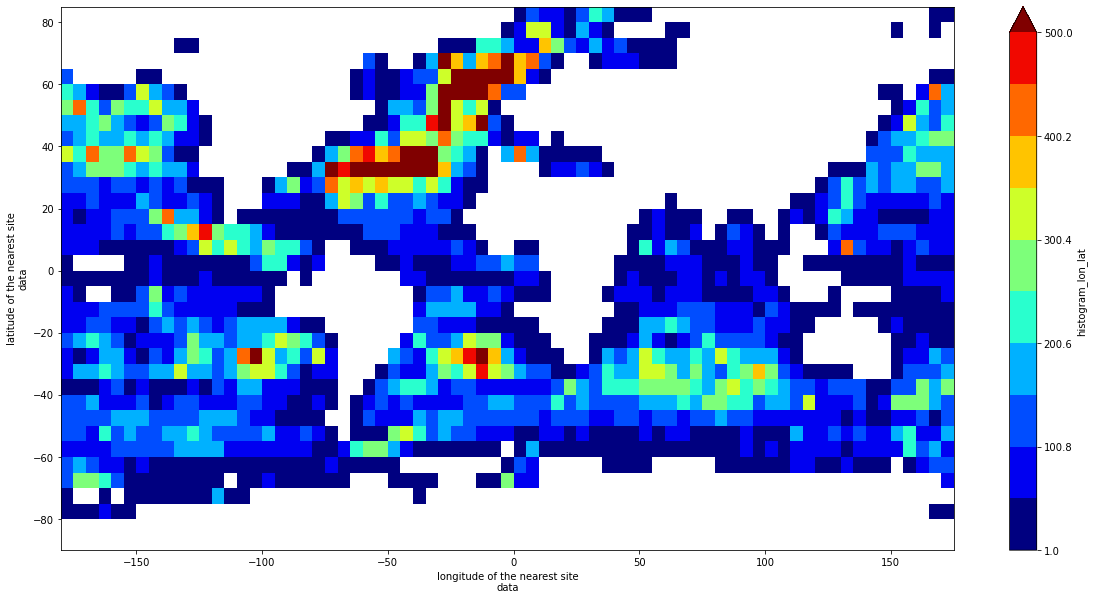

In [13]:
ds_repart_all.plot(x='lon_bin', y='lat_bin', figsize=(20,10),levels = 11, cmap='jet', vmax=500)

In [14]:
acc_bins=np.arange(-1e-4,1e-4,1e-6)
acc_bins1=np.arange(-5e-3,5e-3,1e-5)

bins_list = {"acc": acc_bins, "lon" : lon_bin, "lat": lat_bin}

#ds_pdf = xr.concat([diag.compute_pdfs(DS[key][[var for var in DS[key] if var!='g_grad_x']], bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
#ds_pdf_grad = xr.concat([diag.compute_pdfs(DS[key][['g_grad_x']], acc_bins1) for key in DS],
                        #dim=pd.Index(DS.keys(), name='drifter_sat_year')).rename_dims({'acc_bin':'acc_bin_grad'}).rename({'acc_bin':'acc_bin_grad'})

ds_pdf = xr.concat([diag.compute_pdfs(DS[key], bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
#ds_pdf = xr.merge([ds_pdf, ds_pdf_grad])

In [15]:
ds_pdf_all = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sum('drifter_sat_year')/(ds_pdf.nb_coloc.sum('drifter_sat_year'))#normalized
ds_pdf_all

<xarray.Dataset>
Dimensions:                                               (acc_bin: 200,
                                                           lon_bin: 71,
                                                           lat_bin: 35)
Coordinates:
  * acc_bin                                               (acc_bin) float64 -...
  * lon_bin                                               (lon_bin) float64 -...
  * lat_bin                                               (lat_bin) float64 -...
Data variables: (12/115)
    pdf_box_theta_lon                                     (acc_bin, lon_bin, lat_bin) float64 ...
    pdf___site_indice                                     (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_box_theta_lat                                     (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_theta_lon                                 (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_theta_lat                                 (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_g_grad_x                                          (acc_bin, lon_bin, lat_bin) float64 ...
    ...                                                    ...
    pdf_exc_ggrad_aviso_es_cstrio_z0_drifter_y            (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_exc_wind_aviso_es_cstrio_z0_drifter_y             (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_acc_e                                             (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_acc_n                                             (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_coriolis_e                                        (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_coriolis_n                                        (acc_bin, lon_bin, lat_bin) float64 ...

In [18]:
ds_std_all = diag.ds_mean_var_std(ds_pdf_all,'acc_bin', mean=True, var=True)

In [19]:
ds_std_all

<xarray.Dataset>
Dimensions:                                                (lon_bin: 71,
                                                            lat_bin: 35)
Coordinates:
  * lon_bin                                                (lon_bin) float64 ...
  * lat_bin                                                (lat_bin) float64 ...
Data variables: (12/345)
    mean_box_theta_lon                                     (lon_bin, lat_bin) float64 ...
    var_box_theta_lon                                      (lon_bin, lat_bin) float64 ...
    std_box_theta_lon                                      (lon_bin, lat_bin) float64 ...
    mean___site_indice                                     (lon_bin, lat_bin) float64 ...
    var___site_indice                                      (lon_bin, lat_bin) float64 ...
    std___site_indice                                      (lon_bin, lat_bin) float64 ...
    ...                                                     ...
    mean_coriolis_e                                        (lon_bin, lat_bin) float64 ...
    var_coriolis_e                                         (lon_bin, lat_bin) float64 ...
    std_coriolis_e                                         (lon_bin, lat_bin) float64 ...
    mean_coriolis_n                                        (lon_bin, lat_bin) float64 ...
    var_coriolis_n                                         (lon_bin, lat_bin) float64 ...
    std_coriolis_n                                         (lon_bin, lat_bin) float64 ...

## Mean and std of individual terms

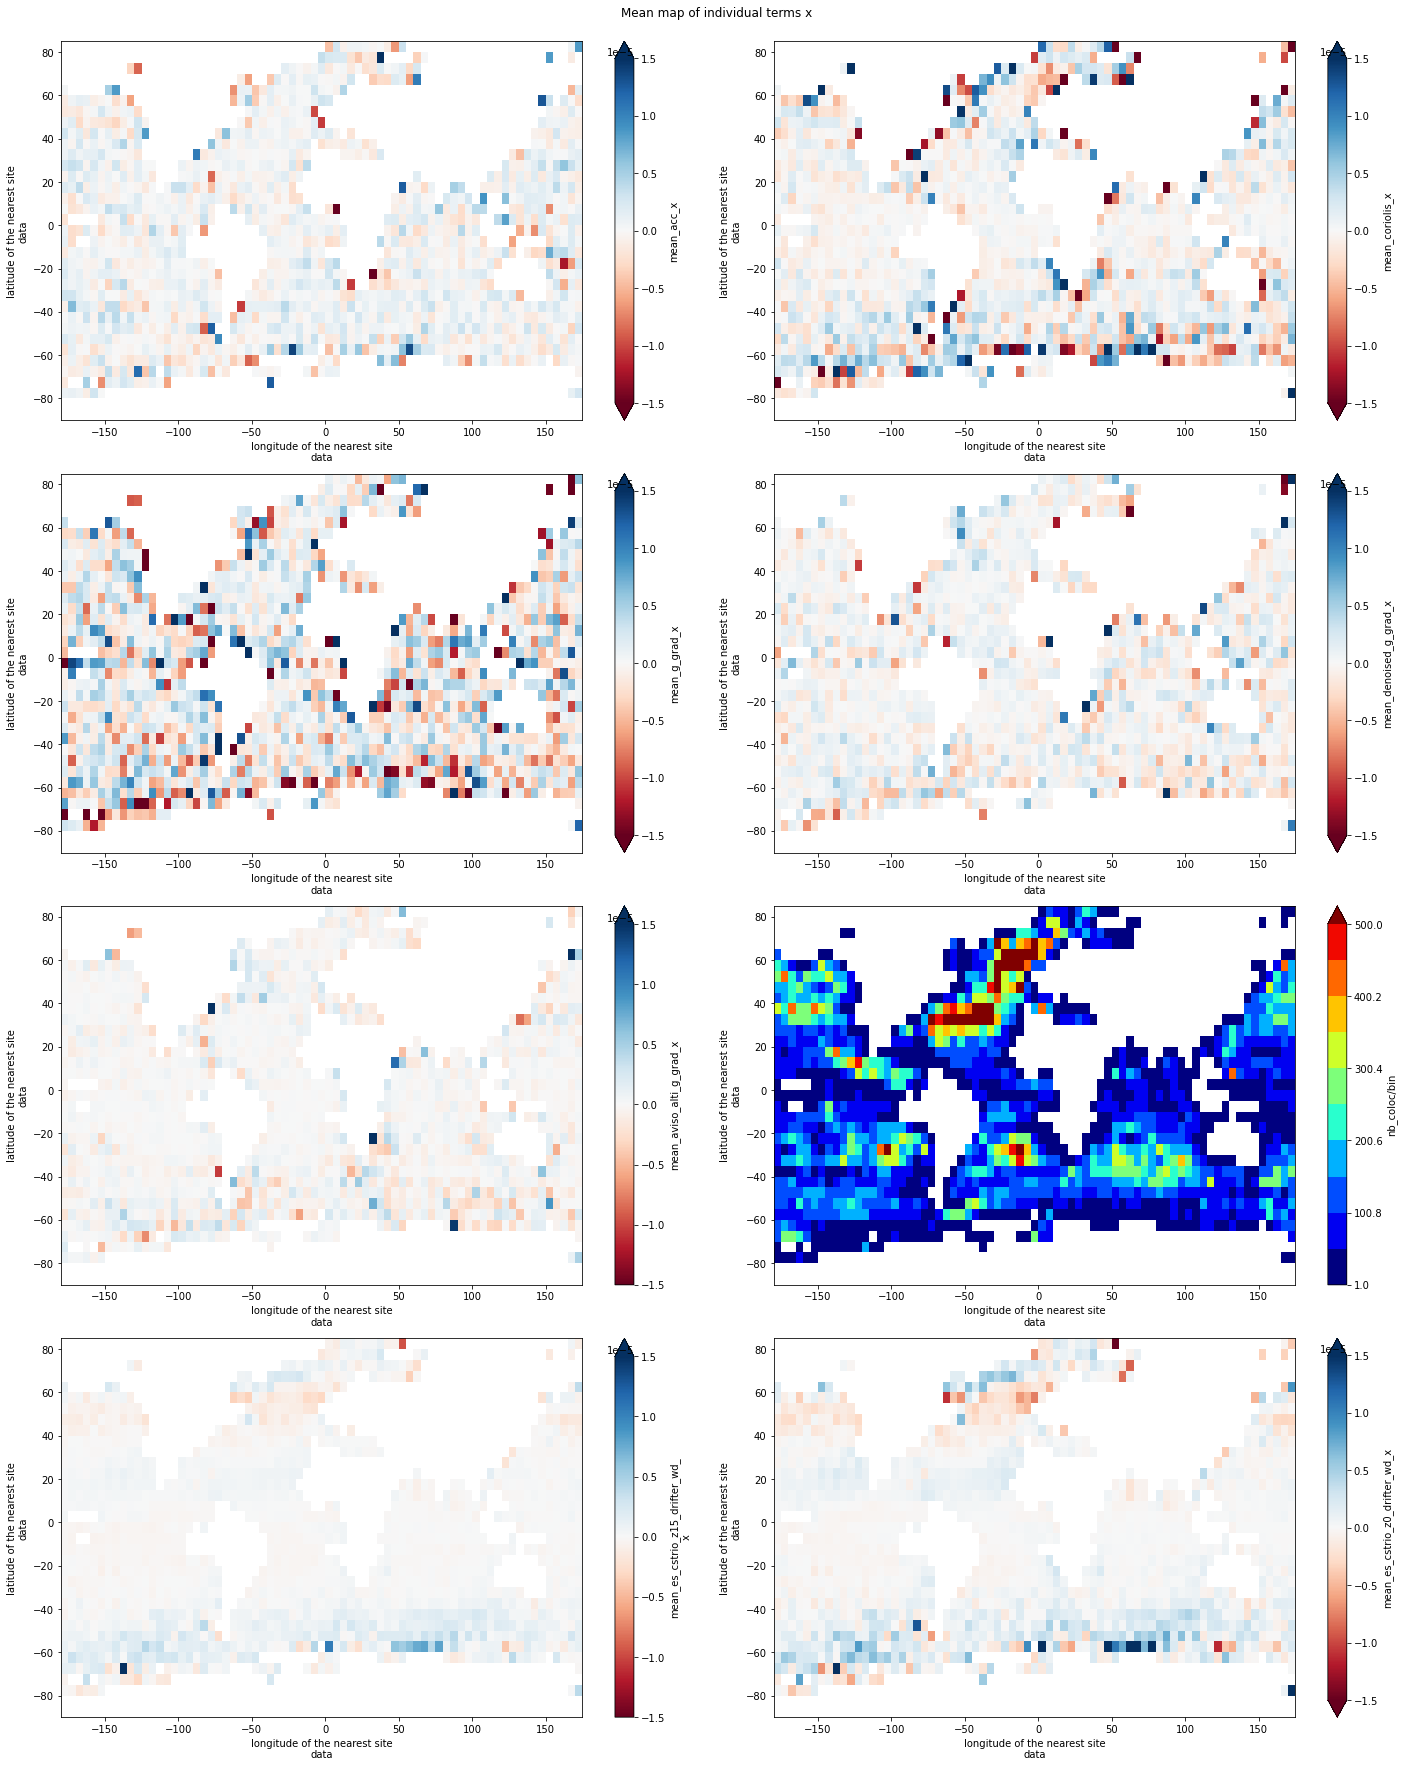

In [20]:
fig, ax = plt.subplots(4,2, figsize=(20,25 ))
ds_std_all['mean_acc_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[0,0])
ds_std_all['mean_coriolis_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[0,1])
ds_std_all['mean_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,0])
ds_std_all['mean_denoised_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,1])
ds_std_all['mean_aviso_alti_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[2,0])
ds_std_all['mean_es_cstrio_z15_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[3,0])
ds_std_all['mean_es_cstrio_z0_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[3,1])

ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin',levels = 11, cmap='jet', vmax=500, ax=ax[2,1])
fig.suptitle('Mean map of individual terms x')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

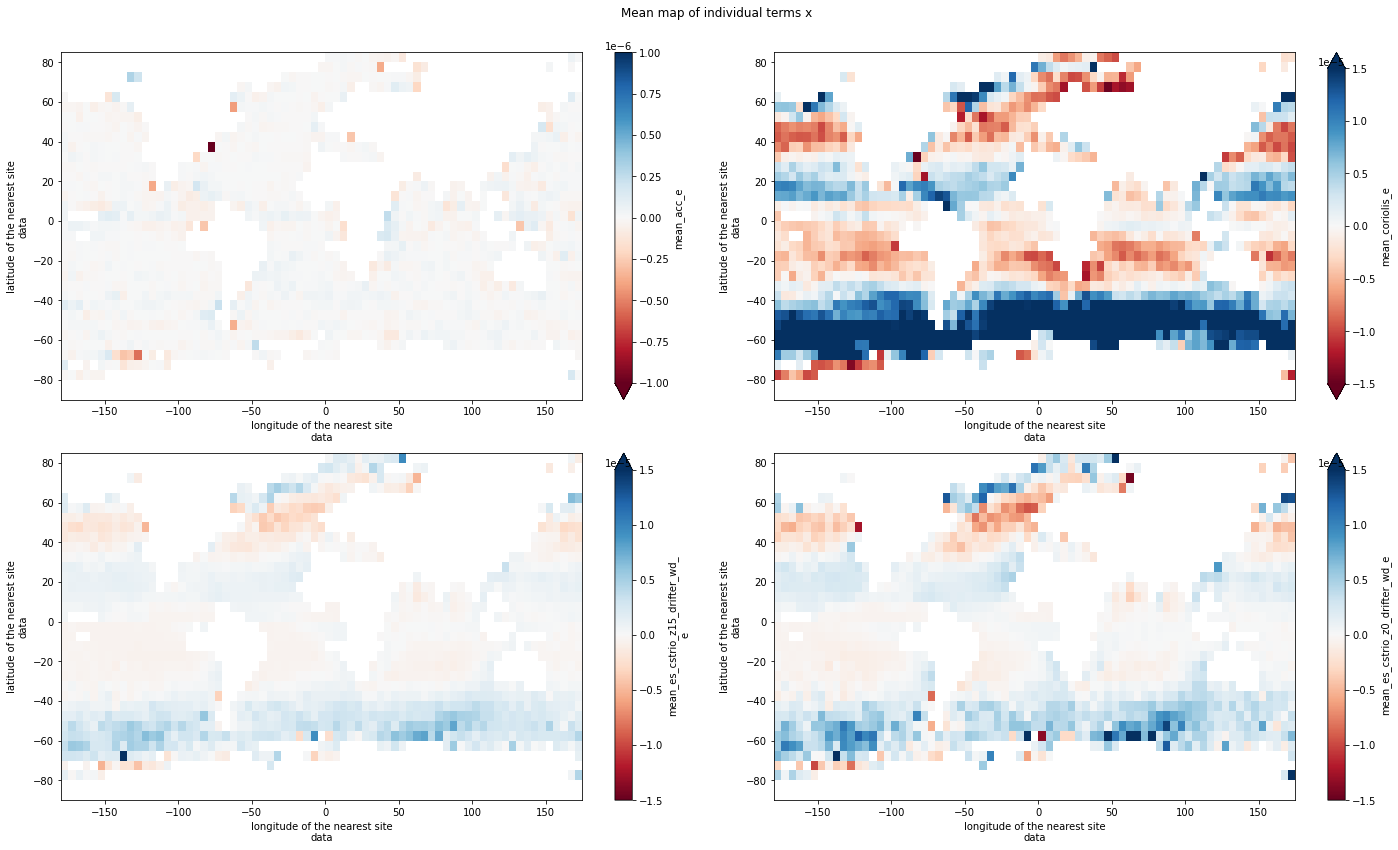

In [30]:
fig, ax = plt.subplots(2,2, figsize=(20,12 ))
ds_std_all['mean_acc_e'].plot(x='lon_bin', y='lat_bin',vmin=-1e-6, vmax=1e-6, cmap='RdBu', ax=ax[0,0])
ds_std_all['mean_coriolis_e'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[0,1])
ds_std_all['mean_es_cstrio_z15_drifter_wd_e'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,0])
ds_std_all['mean_es_cstrio_z0_drifter_wd_e'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,1])

fig.suptitle('Mean map of individual terms x')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

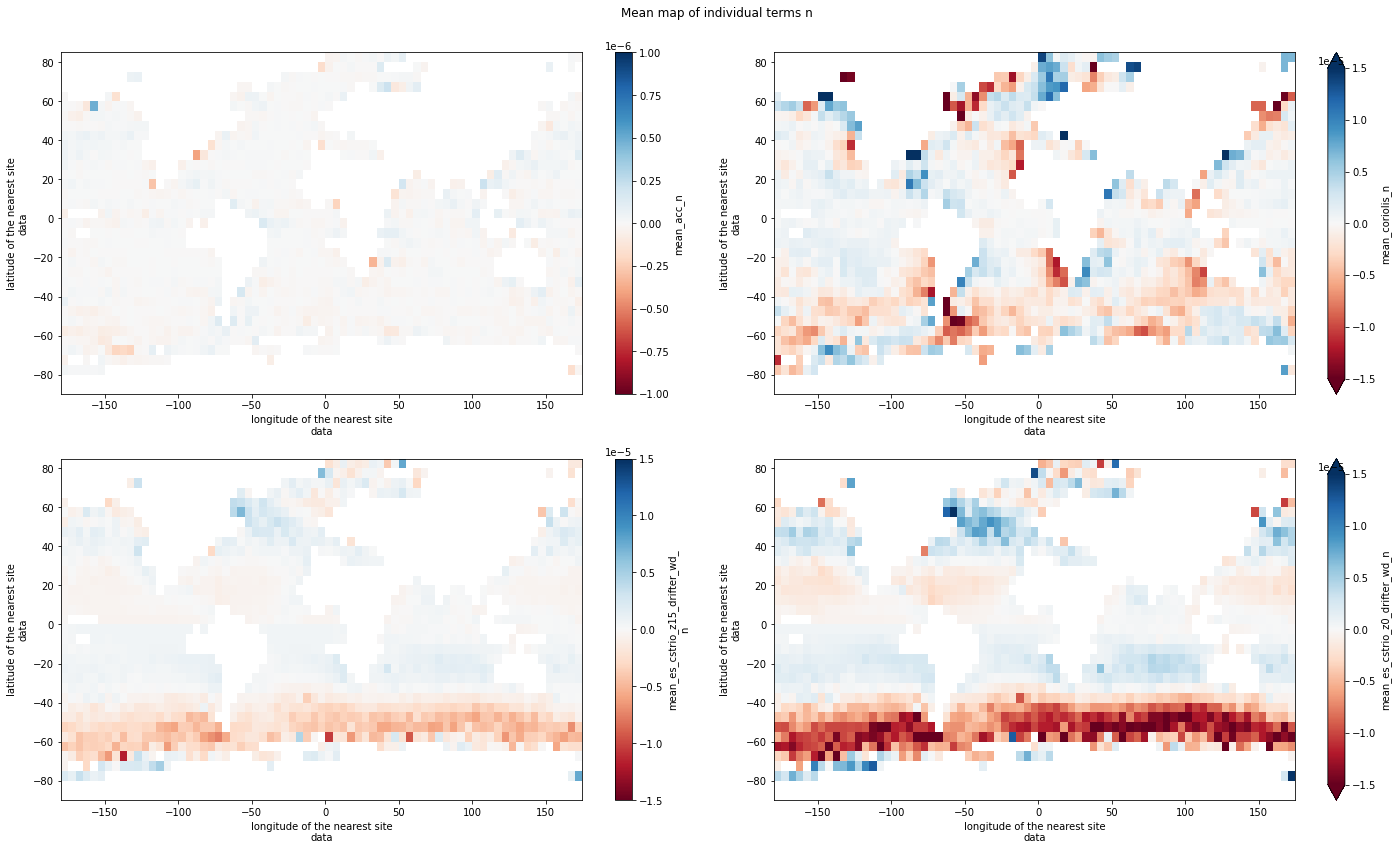

In [31]:
fig, ax = plt.subplots(2,2, figsize=(20,12 ))
ds_std_all['mean_acc_n'].plot(x='lon_bin', y='lat_bin',vmin=-1e-6, vmax=1e-6, cmap='RdBu', ax=ax[0,0])
ds_std_all['mean_coriolis_n'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[0,1])
ds_std_all['mean_es_cstrio_z15_drifter_wd_n'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,0])
ds_std_all['mean_es_cstrio_z0_drifter_wd_n'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5, ax=ax[1,1])

fig.suptitle('Mean map of individual terms n')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

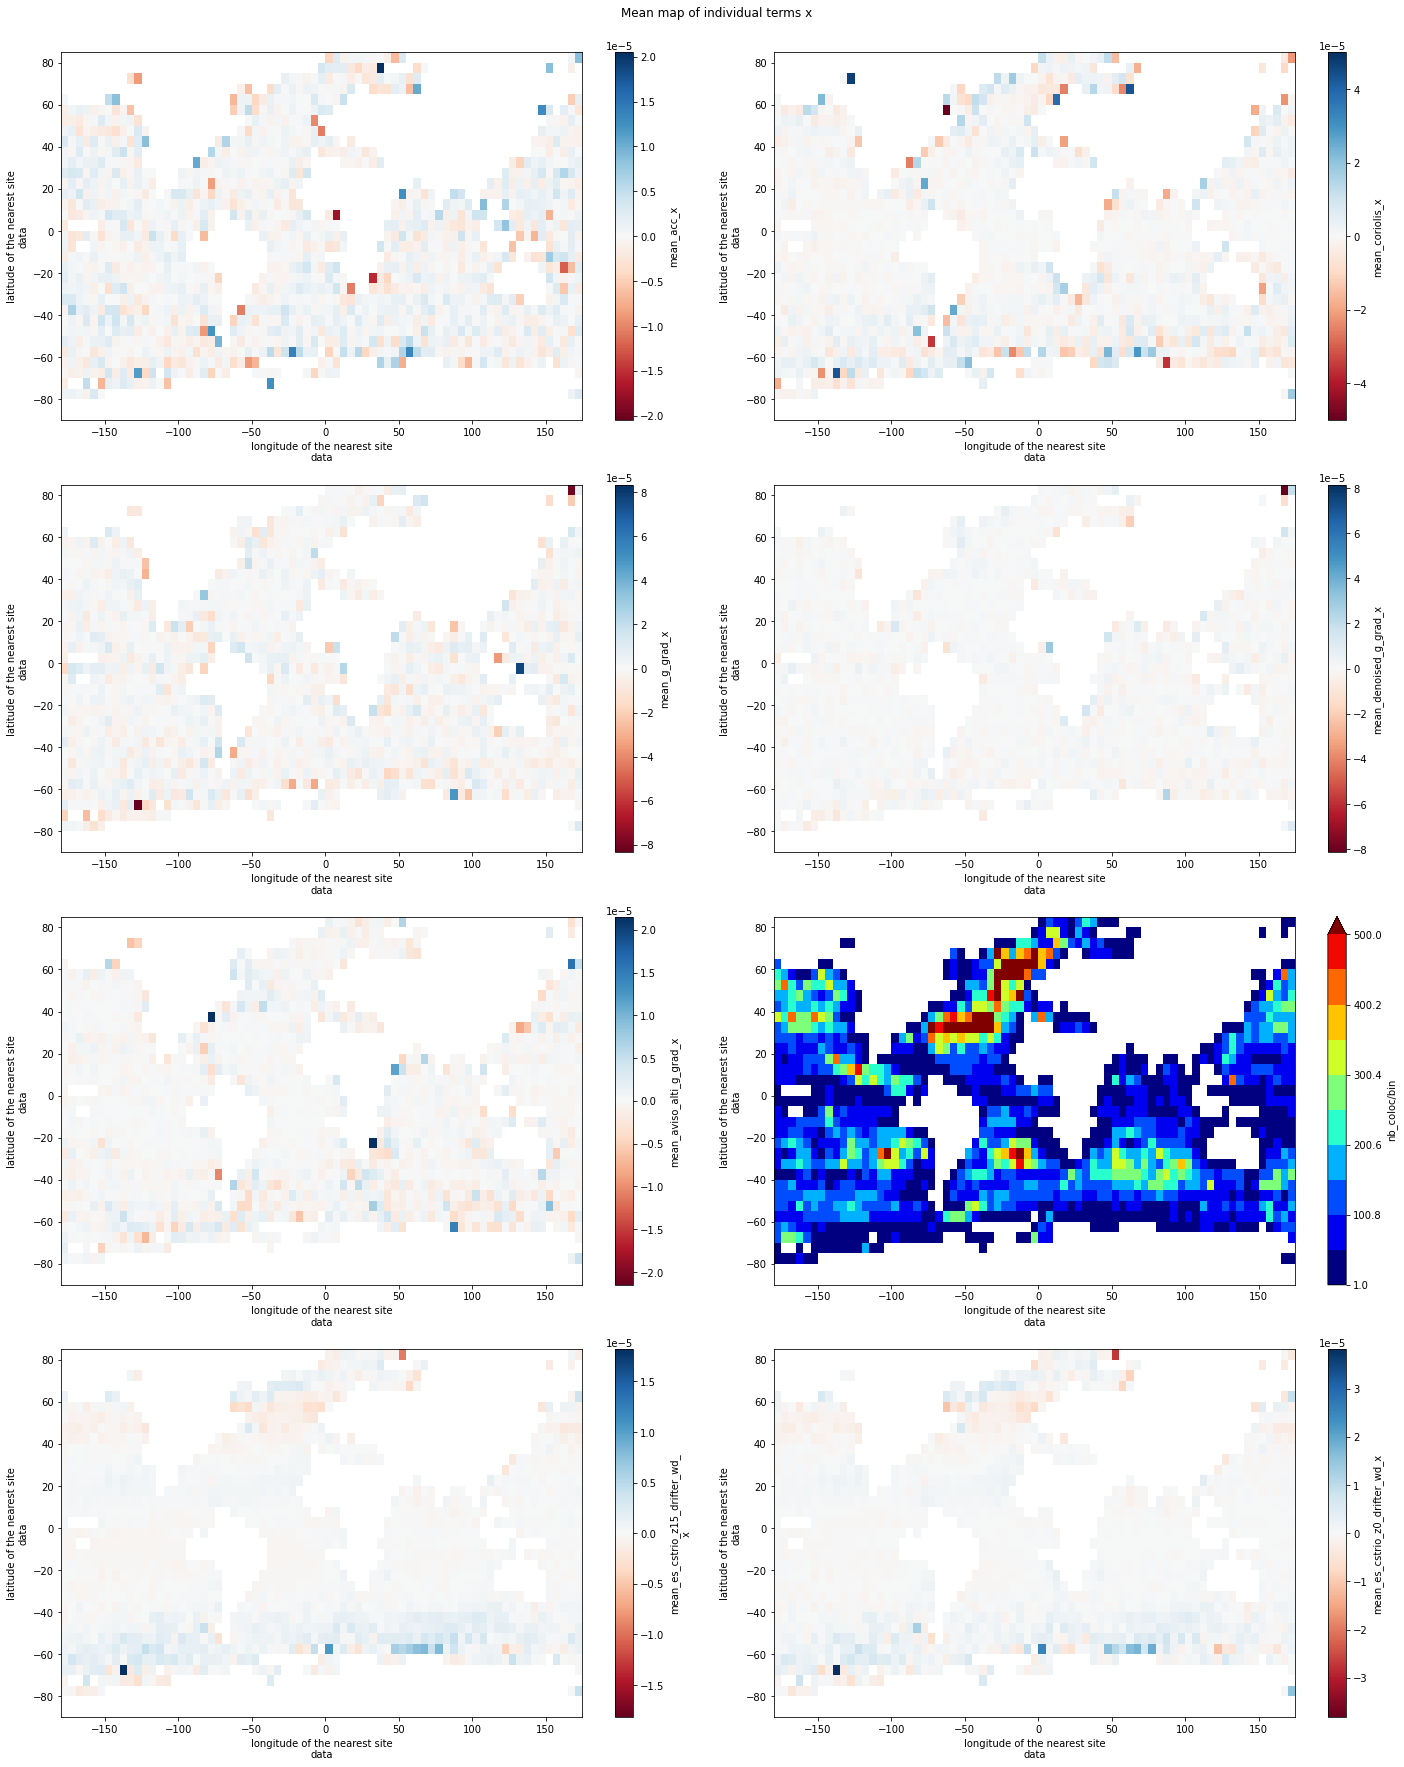

In [33]:
fig, ax = plt.subplots(4,2, figsize=(20,25 ))
ds_std_all['mean_acc_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',  ax=ax[0,0])
ds_std_all['mean_coriolis_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',  ax=ax[0,1])
ds_std_all['mean_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',  ax=ax[1,0])
ds_std_all['mean_denoised_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu', ax=ax[1,1])
ds_std_all['mean_aviso_alti_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',  ax=ax[2,0])
ds_std_all['mean_es_cstrio_z15_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu',  ax=ax[3,0])
ds_std_all['mean_es_cstrio_z0_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='RdBu', ax=ax[3,1])

ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin',levels = 11, cmap='jet', vmax=500, ax=ax[2,1])
fig.suptitle('Mean map of individual terms x')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

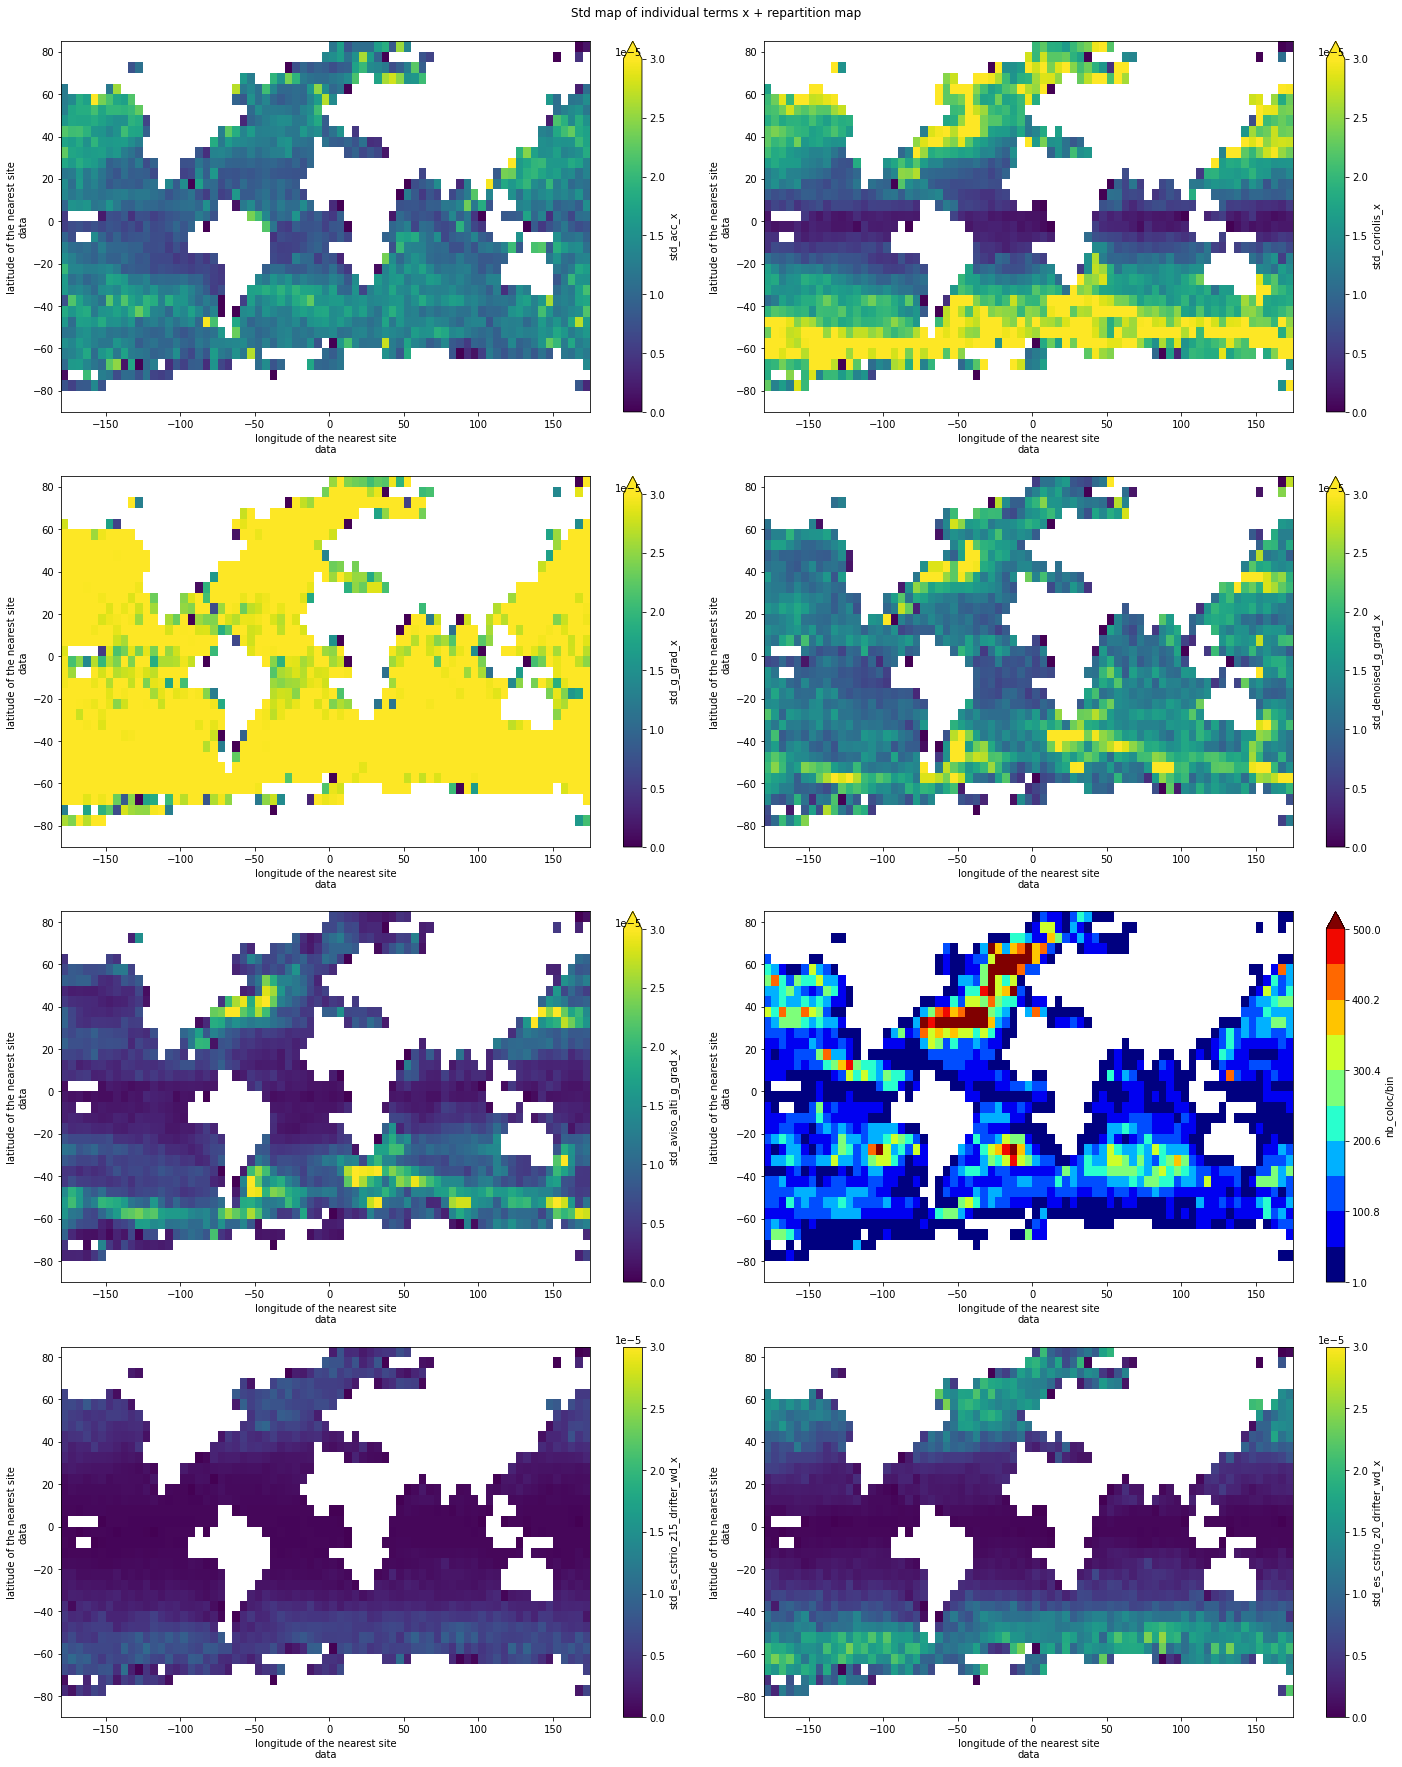

In [34]:
vmax=3e-5
fig, ax = plt.subplots(4,2, figsize=(20,25 ))
ds_std_all['std_acc_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,0])
ds_std_all['std_coriolis_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,1])
ds_std_all['std_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,0])
ds_std_all['std_denoised_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis',vmax=vmax,  ax=ax[1,1])
ds_std_all['std_aviso_alti_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[2,0])
ds_std_all['std_es_cstrio_z15_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[3,0])
ds_std_all['std_es_cstrio_z0_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[3,1])

ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin',levels = 11, cmap='jet', vmax=500, ax=ax[2,1])

fig.suptitle('Std map of individual terms x + repartition map')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

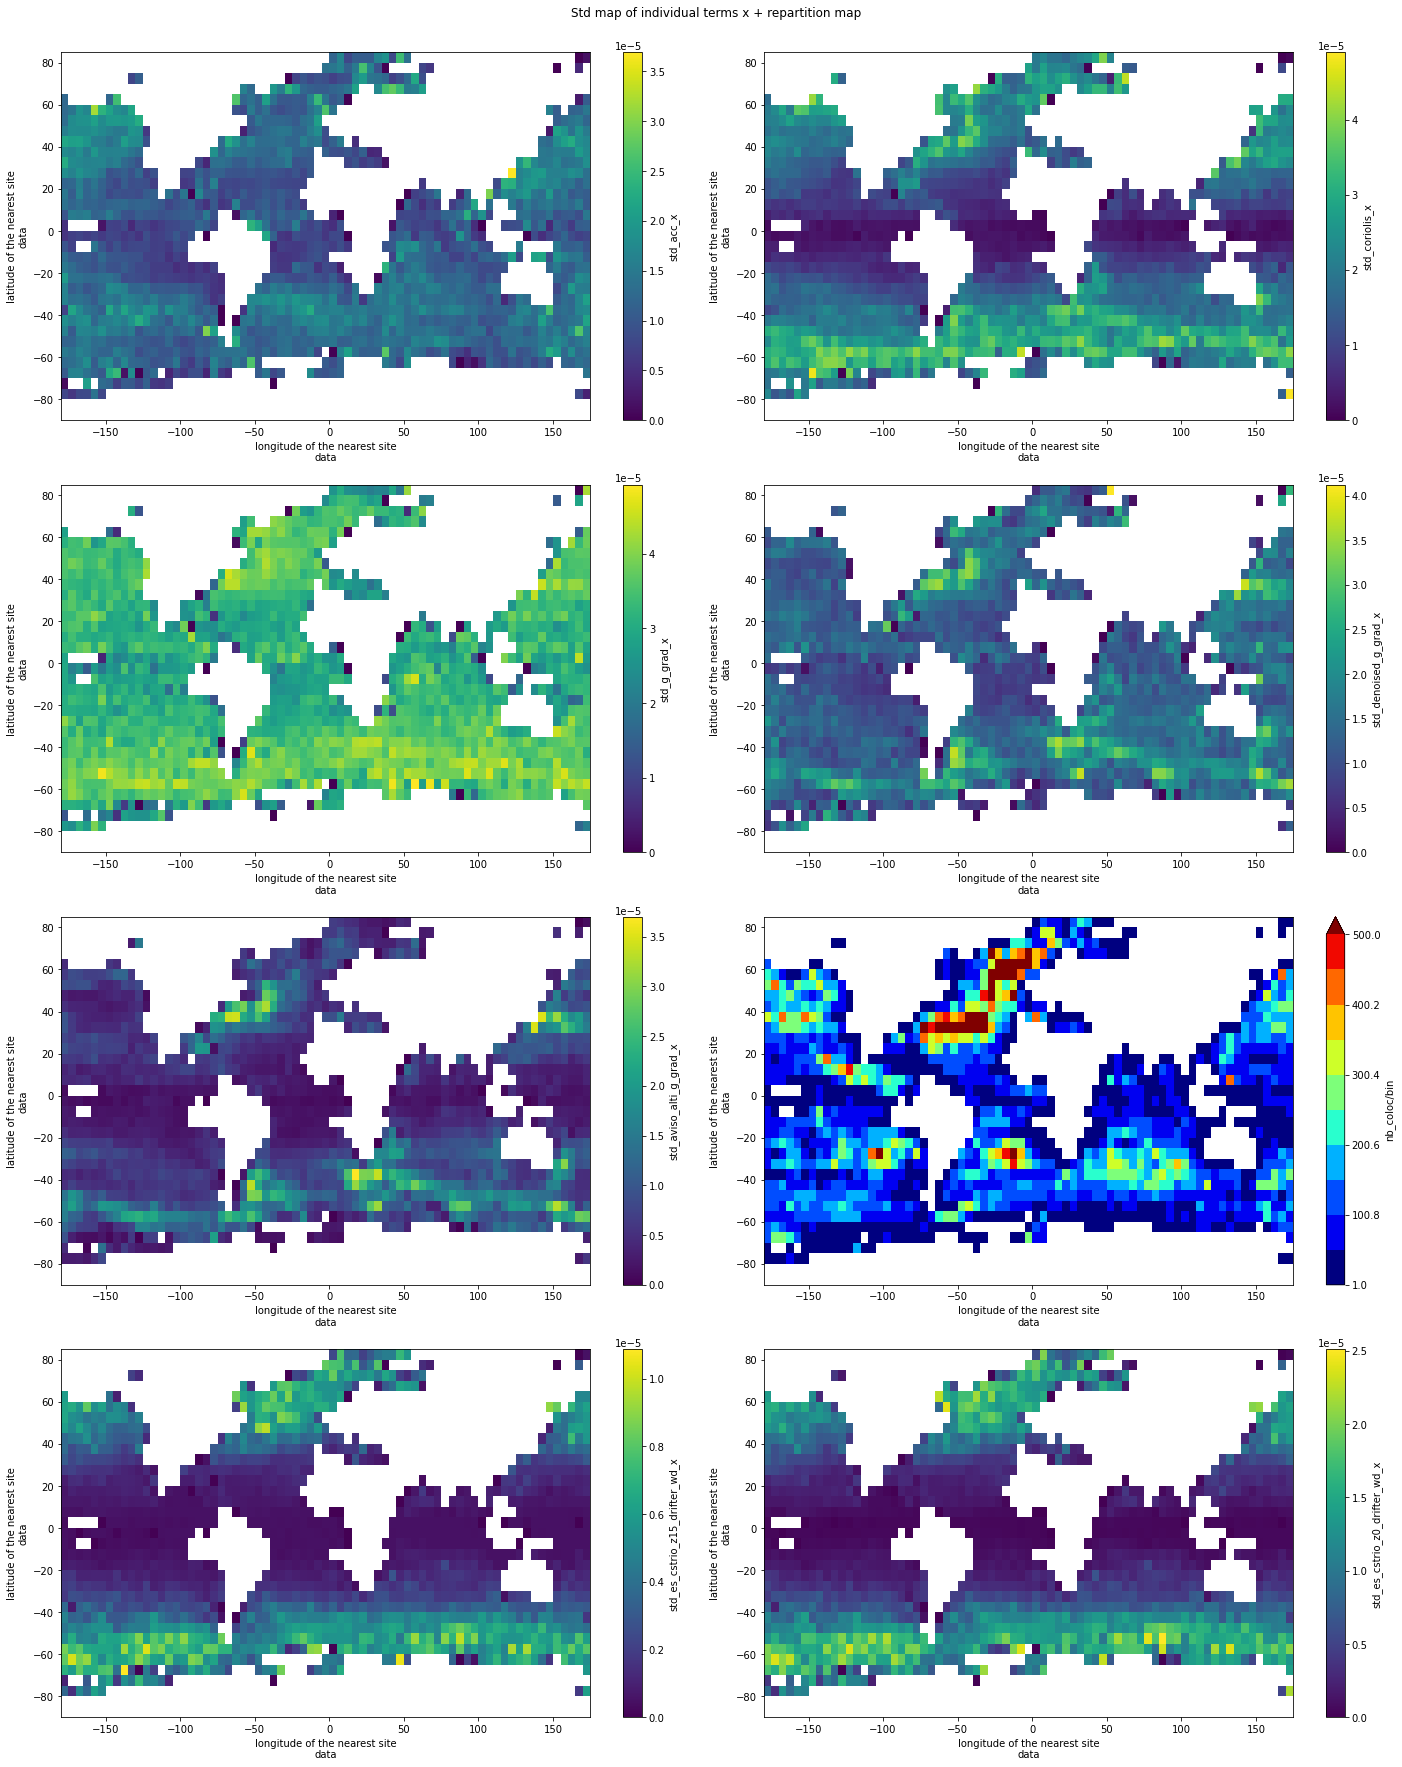

In [57]:
vmax=3e-5
fig, ax = plt.subplots(4,2, figsize=(20,25 ))
ds_std_all['std_acc_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', ax=ax[0,0])
ds_std_all['std_coriolis_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis',  ax=ax[0,1])
ds_std_all['std_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', ax=ax[1,0])
ds_std_all['std_denoised_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis',  ax=ax[1,1])
ds_std_all['std_aviso_alti_g_grad_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', ax=ax[2,0])
ds_std_all['std_es_cstrio_z15_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis',  ax=ax[3,0])
ds_std_all['std_es_cstrio_z0_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', cmap='viridis', ax=ax[3,1])

ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin',levels = 11, cmap='jet', vmax=500, ax=ax[2,1])

fig.suptitle('Std map of individual terms x + repartition map')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

In [33]:
#ds_std_all['mean_acc_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [34]:
#ds_std_all['mean_coriolis_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [35]:
#ds_std_all['mean_g_grad_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [36]:
#ds_std_all['mean_denoised_g_grad_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [37]:
#ds_std_all['mean_aviso_alti_g_grad_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [38]:
#(ds_std_all['mean_aviso_alti_g_grad_x']-ds_std_all['mean_denoised_g_grad_x']).plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [39]:
#ds_std_all['mean_es_cstrio_z15_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [40]:
#ds_std_all['mean_es_cstrio_z0_drifter_wd_x'].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

## STD and mean values map for erastar 0m, drifter matchup, grad coloc
### mean sum of all

Text(0.5, 1.0, 'Mean of S for co_denoised_es_cstrio_z0_drifter_x')

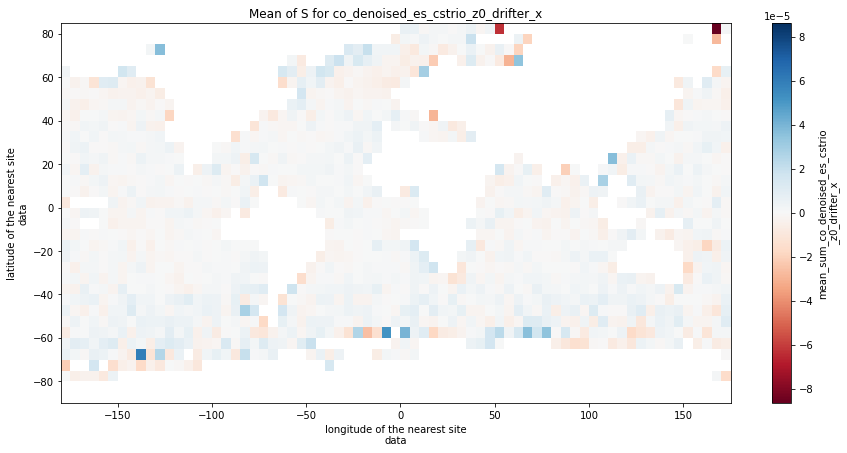

In [41]:
id_ = 'co_denoised_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_)

Text(0.5, 1.0, 'Mean of S for co_denoised_es_cstrio_z0_drifter_x')

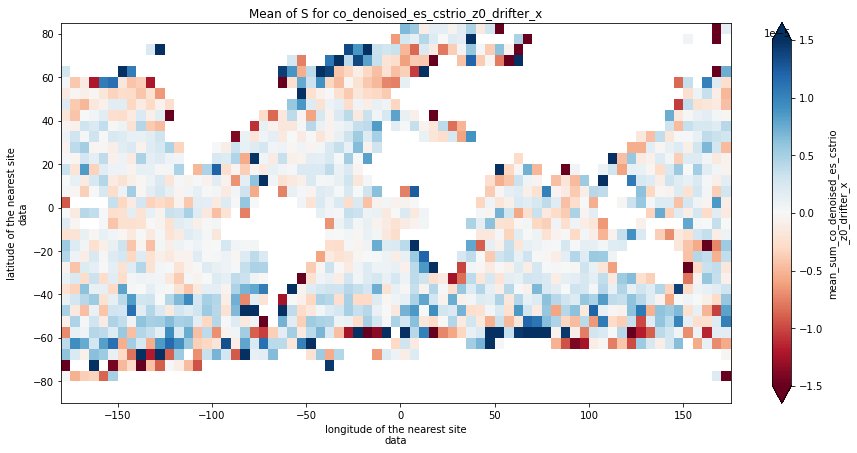

In [42]:
id_ = 'co_denoised_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_)

### std sum of all

Text(0.5, 1.0, 'Std of S for co_denoised_es_cstrio_z0_drifter_x')

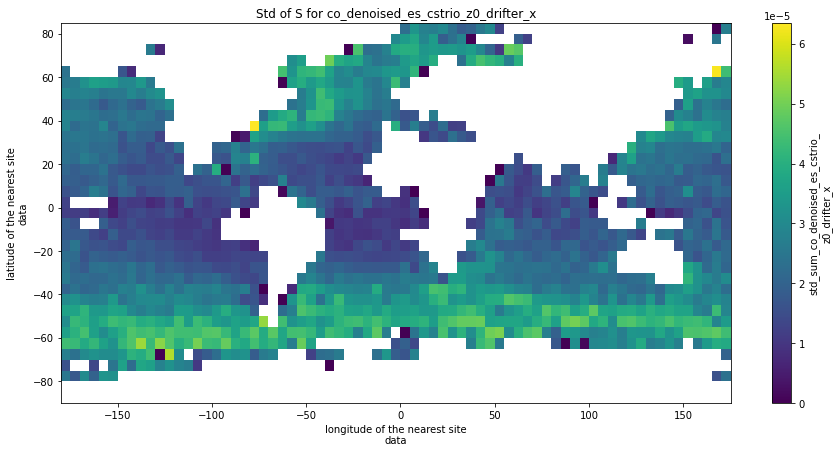

In [43]:
ds_std_all['std_sum_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Std of S for ' +id_)

### Except sum


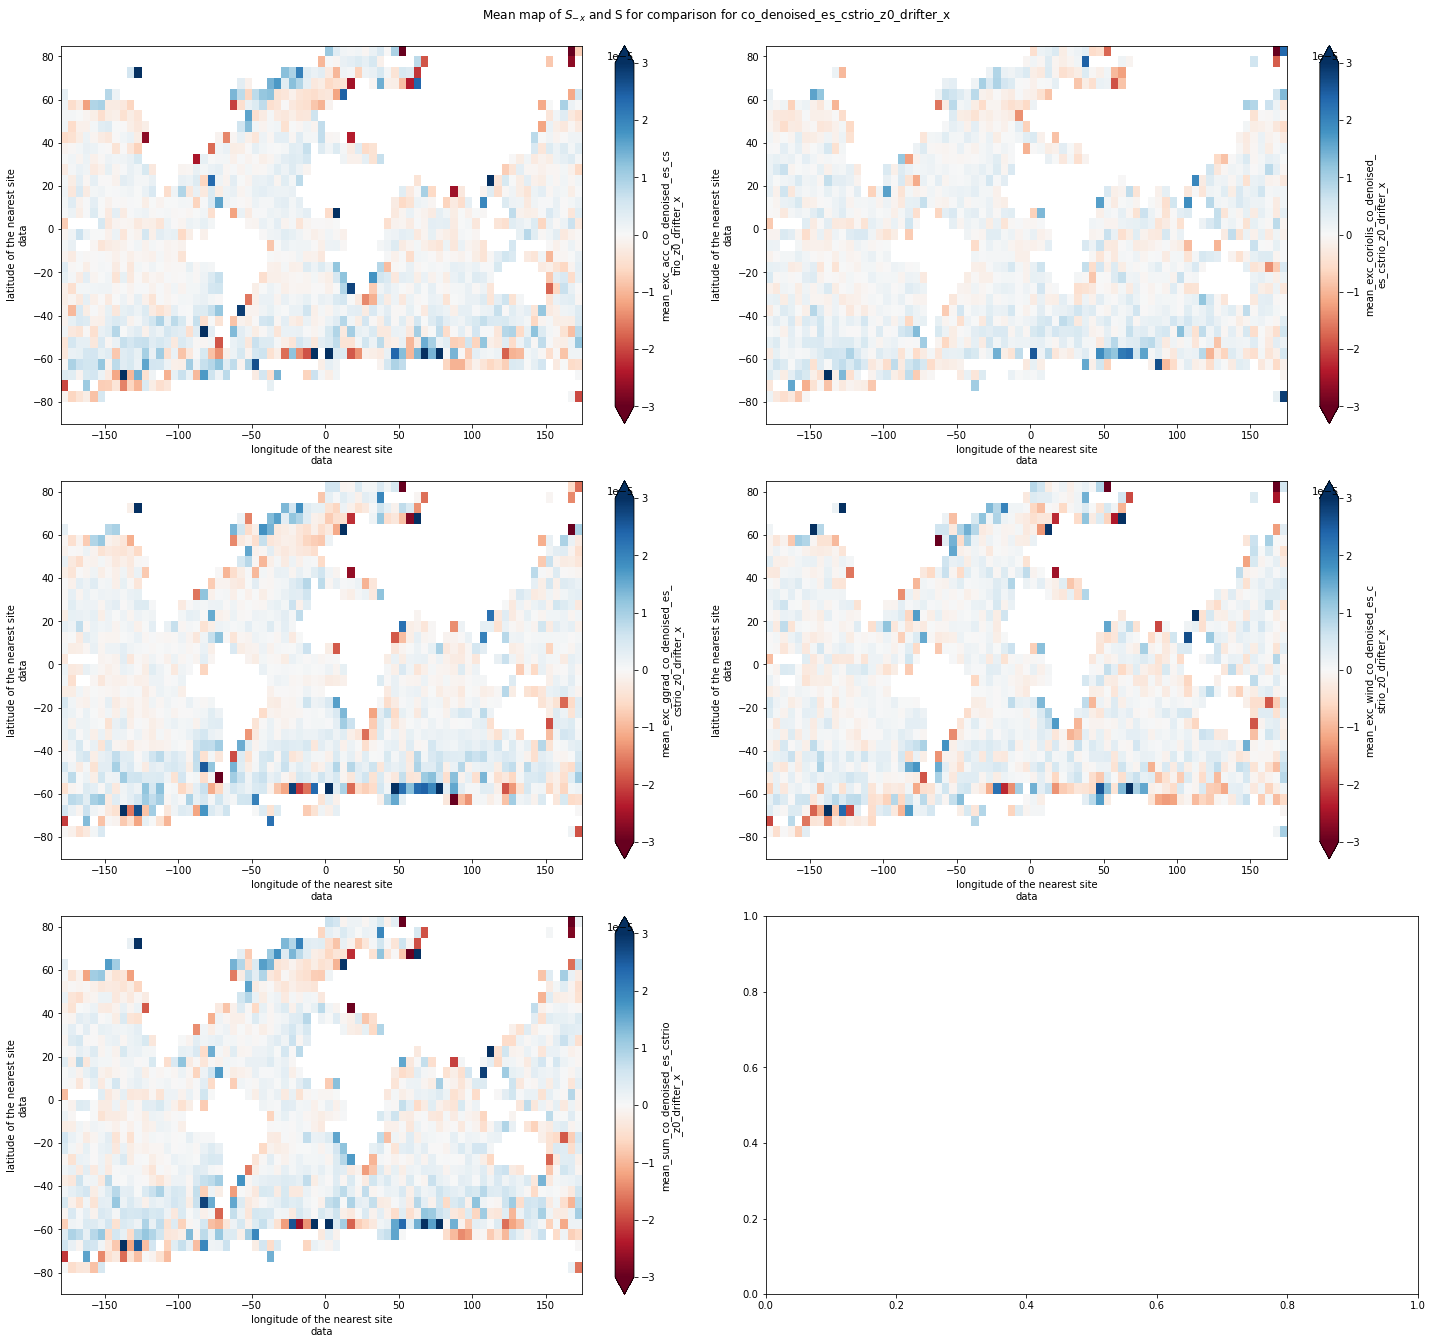

In [44]:
vmax=3e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['mean_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,0])
ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,1])
ds_std_all['mean_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,0])
ds_std_all['mean_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,1])
ds_std_all['mean_sum_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Mean map of $S_{-x}$ and S for comparison for ' +id_)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

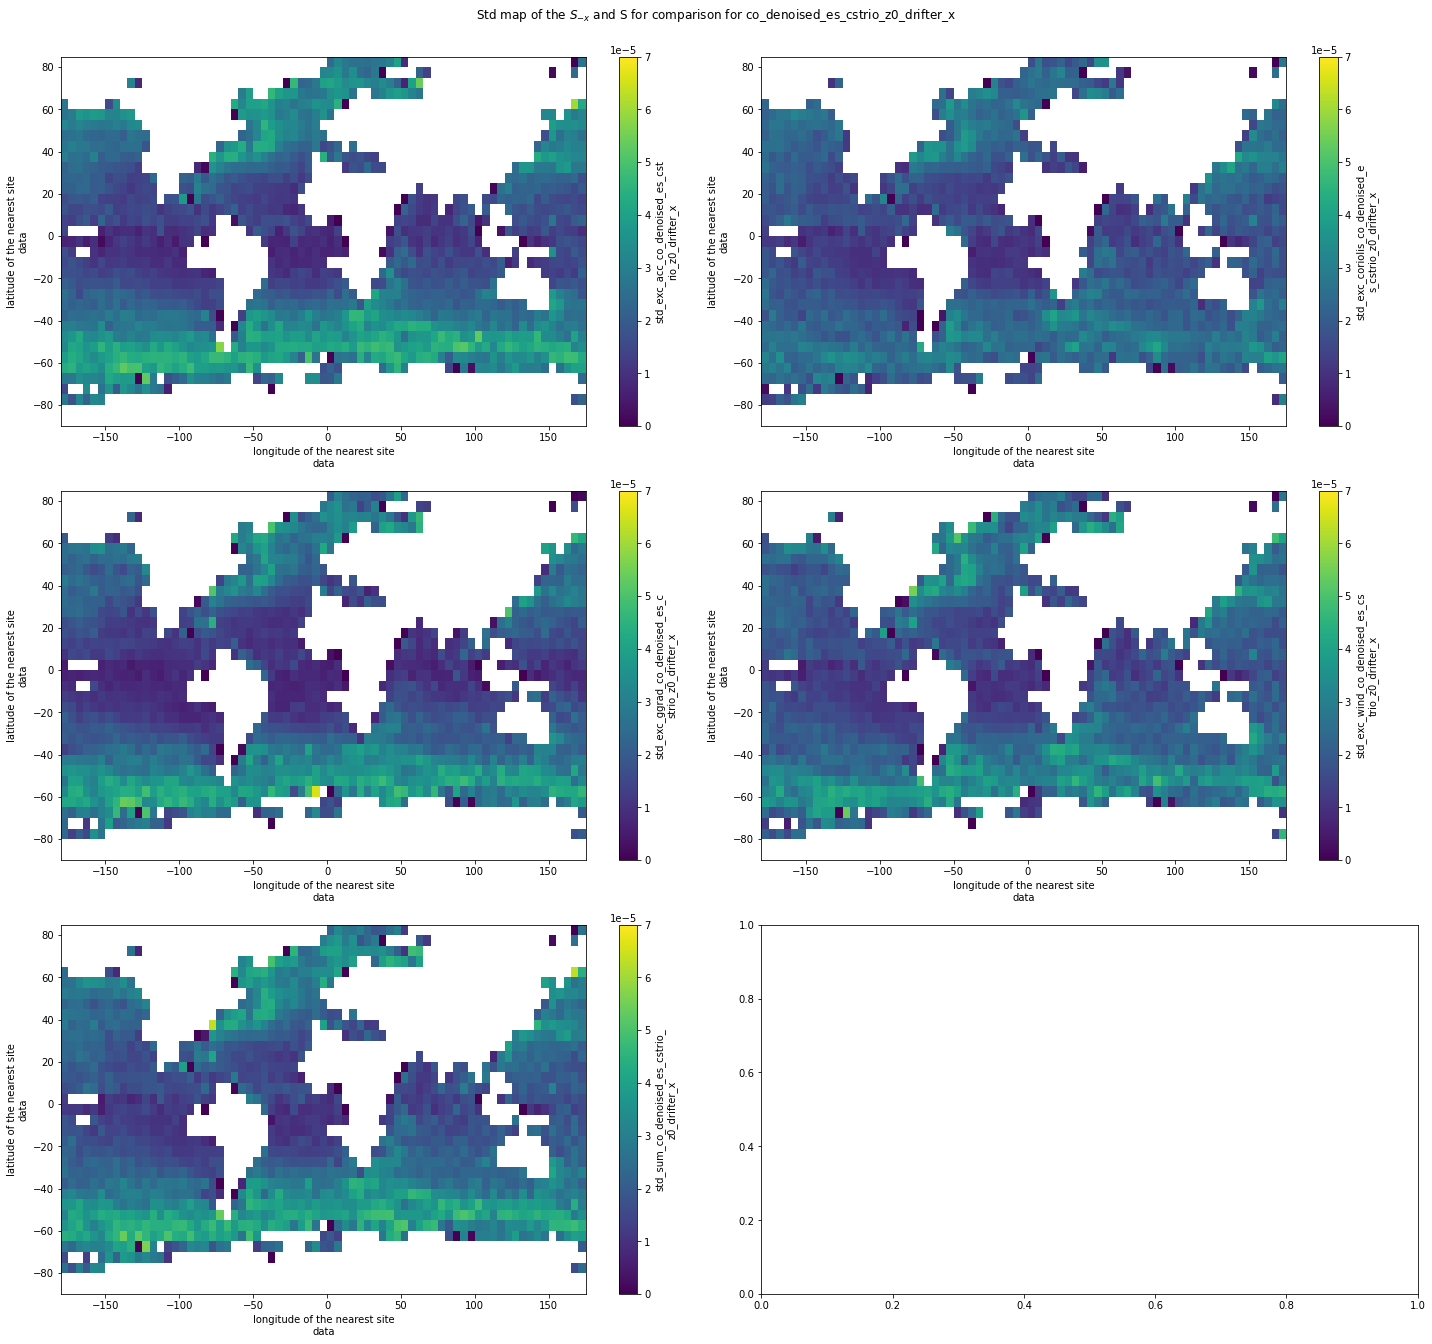

In [45]:
vmax=7e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['std_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,0])
ds_std_all['std_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,1])
ds_std_all['std_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,0])
ds_std_all['std_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,1])
ds_std_all['std_sum_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Std map of the $S_{-x}$ and S for comparison for ' +id_)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

In [46]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-3.5e-5, vmax=3.5e-5,)

In [47]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-3.5e-5, vmax=3.5e-5,)

In [48]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [49]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

#### except std

In [50]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['std_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis')#,vmin=-1.5e-5, vmax=1.5e-5,)

In [51]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-2e-5, vmax=1.5e-5,)

## STD and mean values map for erastar 0m, drifter matchup, grad aviso
### mean sum of all

Text(0.5, 1.0, 'Mean of S for aviso_es_cstrio_z0_drifter_x')

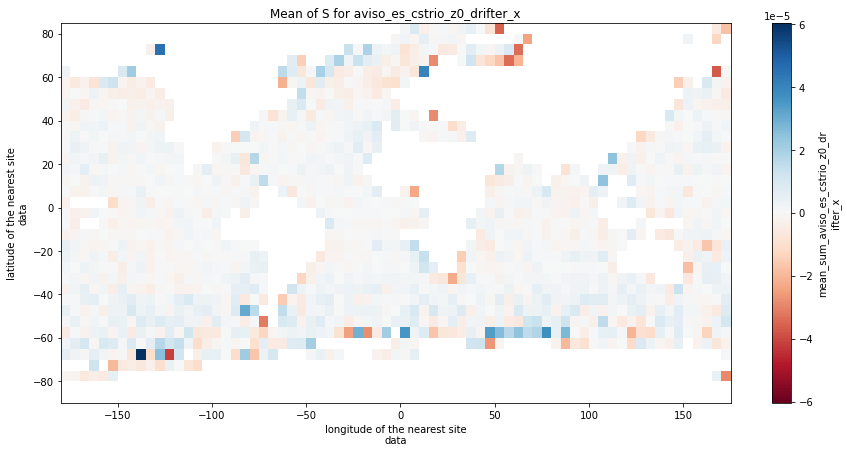

In [52]:
id_2 = 'aviso_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_2)

Text(0.5, 1.0, 'Mean of S for aviso_es_cstrio_z0_drifter_x')

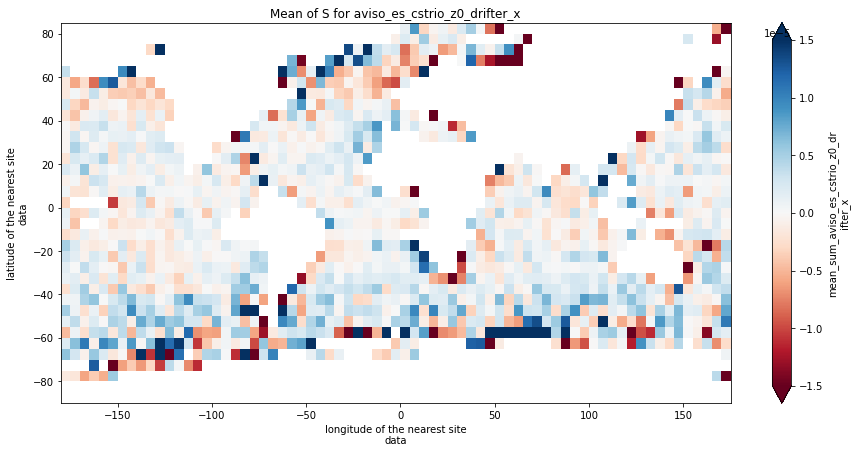

In [53]:
id_2 = 'aviso_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_2)

Text(0.5, 1.0, 'Std of S for aviso_es_cstrio_z0_drifter_x')

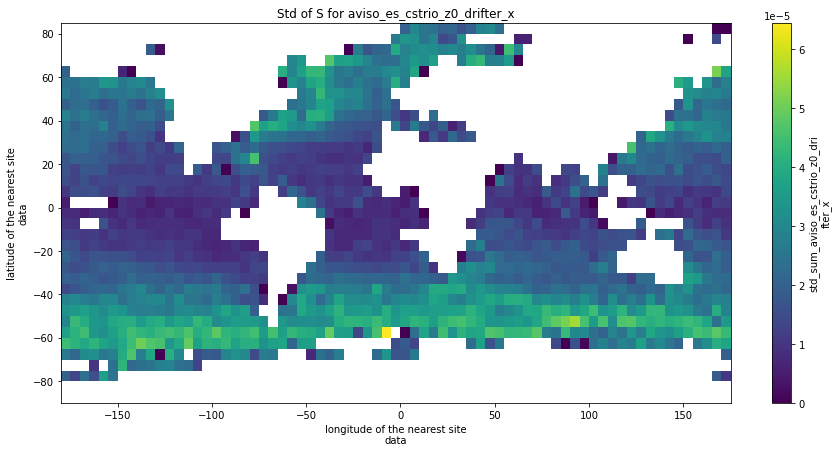

In [54]:
ds_std_all['std_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Std of S for ' +id_2)

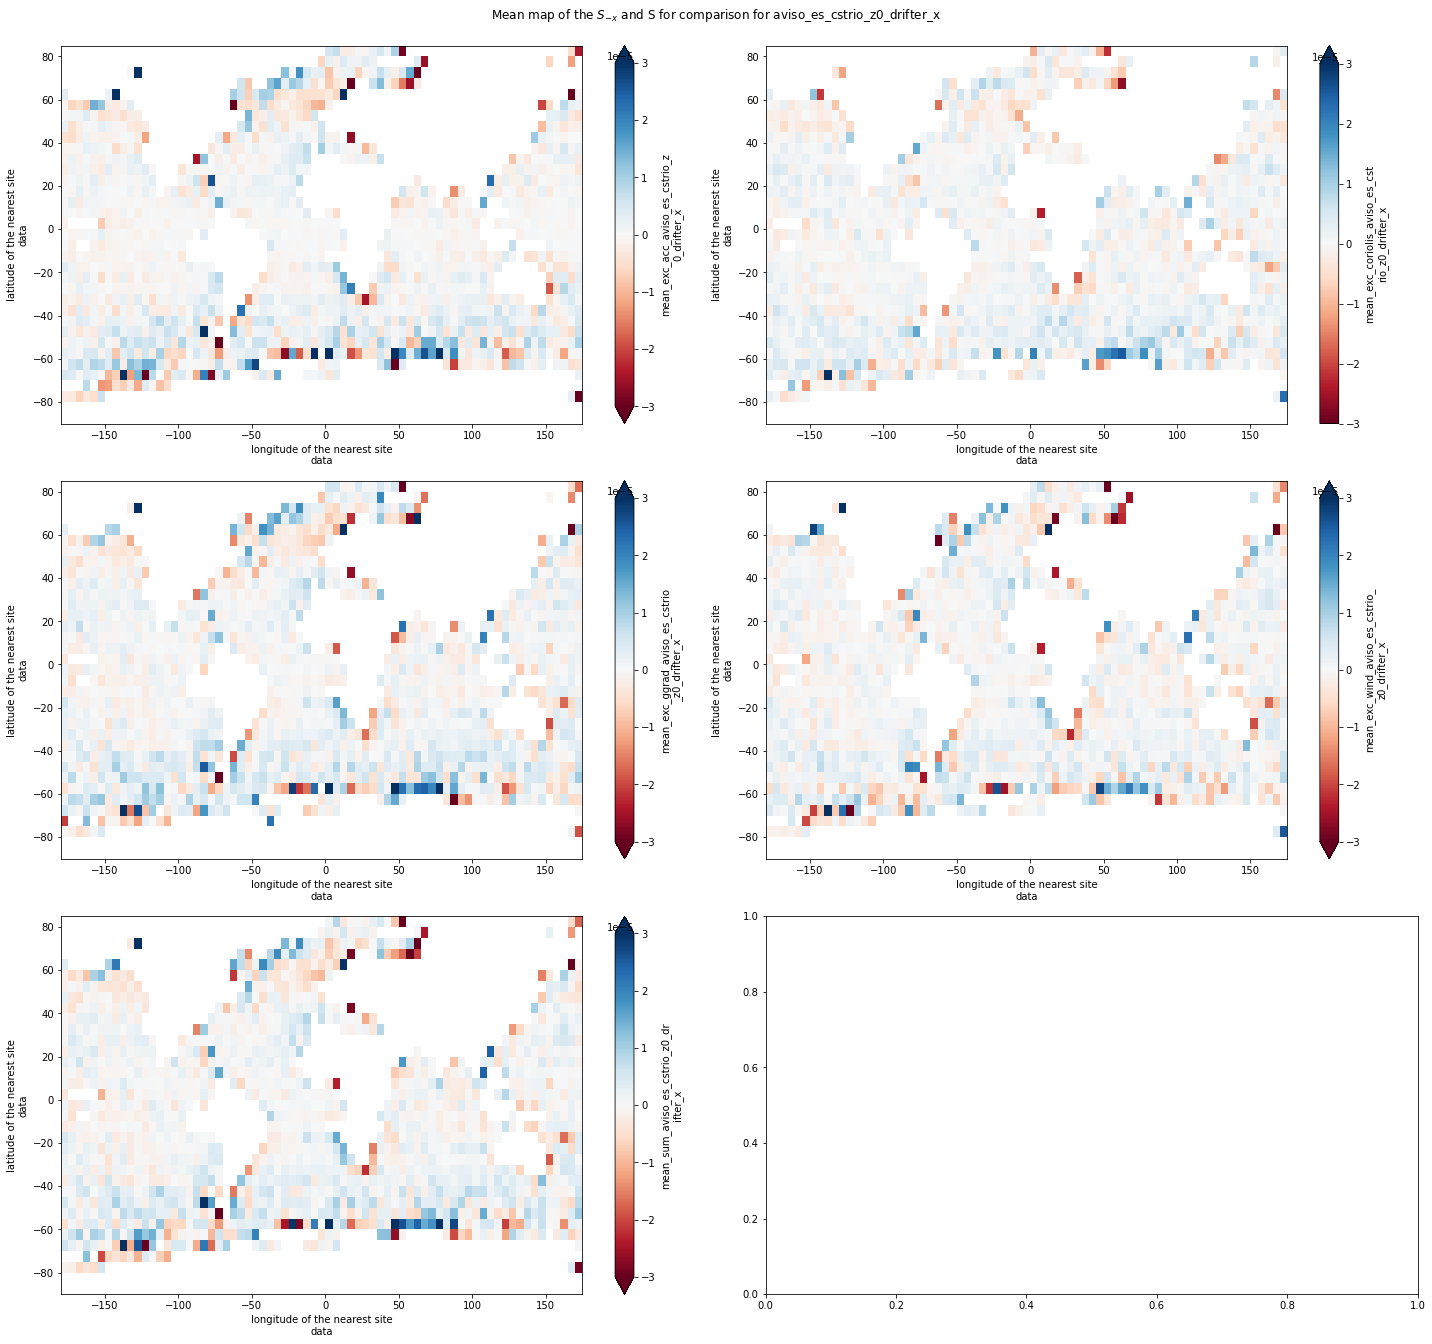

In [55]:
vmax=3e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['mean_exc_acc_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,0])
ds_std_all['mean_exc_coriolis_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,1])
ds_std_all['mean_exc_ggrad_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,0])
ds_std_all['mean_exc_wind_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,1])
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Mean map of the $S_{-x}$ and S for comparison for ' +id_2)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

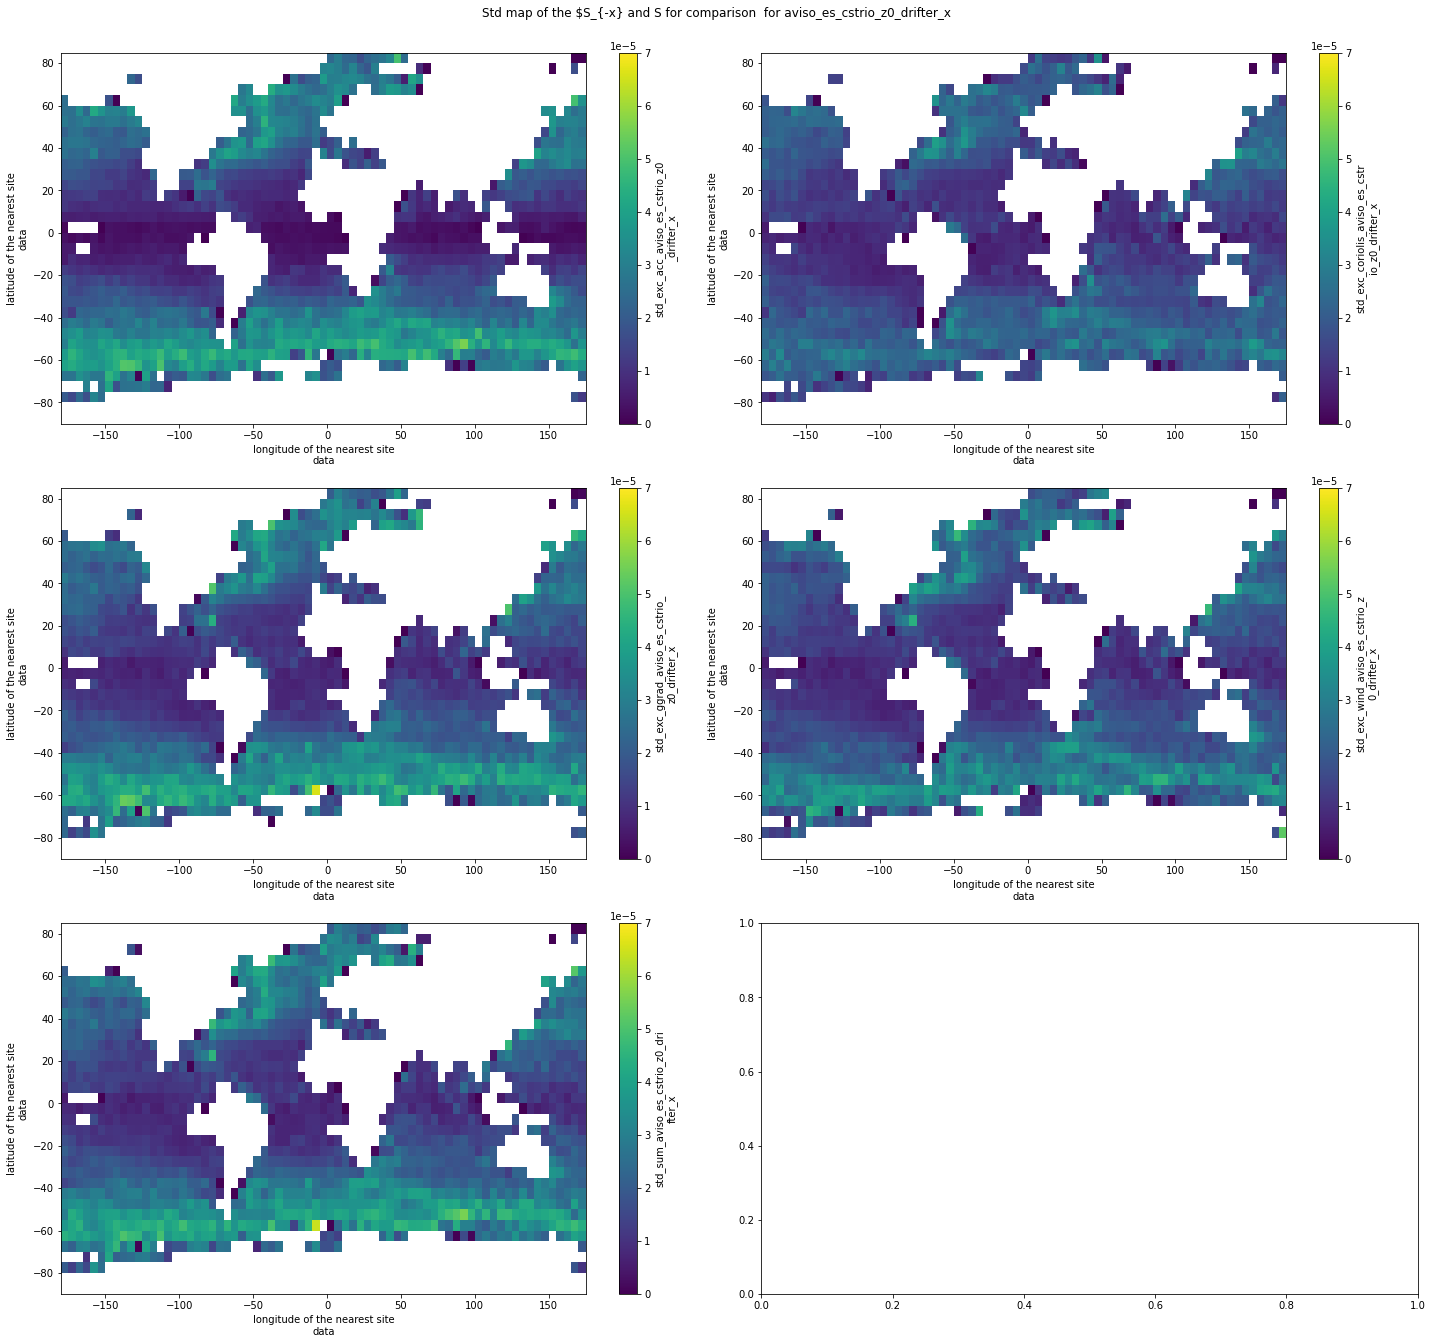

In [56]:
vmax=7e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['std_exc_acc_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,0])
ds_std_all['std_exc_coriolis_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,1])
ds_std_all['std_exc_ggrad_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,0])
ds_std_all['std_exc_wind_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,1])
ds_std_all['std_sum_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Std map of the $S_{-x} and S for comparison  for ' +id_2)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

In [44]:
cluster.close()